# Определение возраста покупателей

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

## Исследовательский анализ данных

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


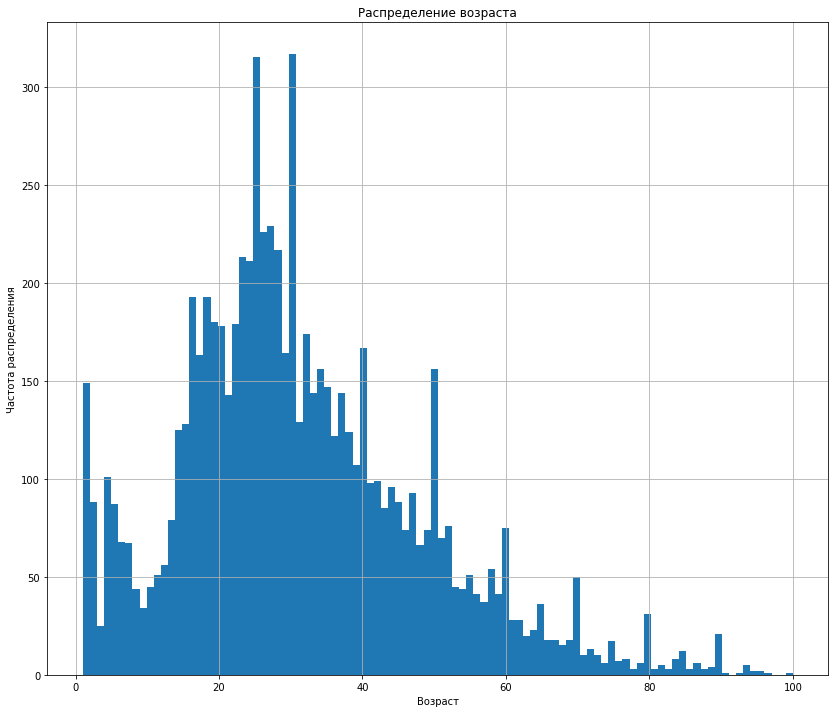

In [ ]:
plt.hist(x=labels['real_age'],bins=100)
plt.rcParams["figure.figsize"] = (10,12)
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота распределения')
plt.grid()


In [ ]:
train_gen_flow.next()[0].shape

(32, 224, 224, 3)

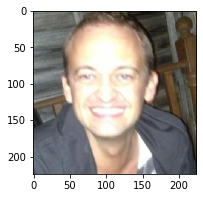

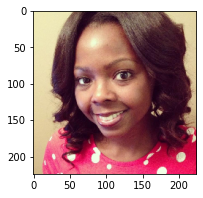

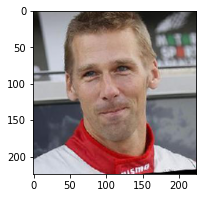

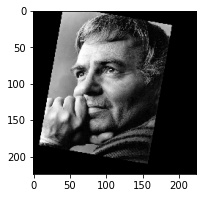

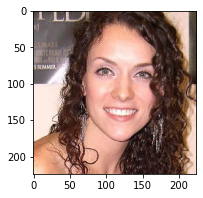

In [ ]:
for _ in range(5):
    img, label=train_gen_flow.next()
    plt.rcParams["figure.figsize"] = (3,3)
    plt.imshow(img[0])
    
    plt.show();

Вывод:

По графику распределения возраста видно, что у нас является скопление людей молодого возраста от 18 до 30, а так же много детей до 10 лет. Такое распределение может негативно сказываться на качестве обучения, так как модель видит меньше людей 30+, и очень много 25-30. Но возможно в задаче регрессии это не так критично. Возможно всеже модель чаще будет ошибаться в сторону меньшего возраста в предсказании.

По фото видно, что действительно изображения отцентрованы и их можно подавать на обучение практически без обработки, кроме нормализации пикселей ( что мы сделали благодаря rescale)

## Обучение модели

```python

import tensorflow as tf
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Conv2D,
    AvgPool2D,
    Flatten,
    BatchNormalization,
    GlobalAveragePooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError

# import tensorflow_addons as tfa
# from tf.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam

# from tfa.optimizers import AdamW
# from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_train(path):
    # ResNet50
    # print(path)
    lables = pd.read_csv(path + "labels.csv")

    dir = path + "final_files/"

    datagen = ImageDataGenerator(
        validation_split=0.25, rescale=1.0 / 255, rotation_range=60
    )

    train_data = datagen.flow_from_dataframe(
        dataframe=lables,
        directory="/datasets/faces/final_files/",
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        subset="training",
        x_col="file_name",
        y_col="real_age",
        seed=12345,
    )

    return train_data


def load_test(path):
    # ResNet50
    # print(path)
    lables = pd.read_csv(path + "labels.csv")
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1.0 / 255)
    test_data = datagen.flow_from_dataframe(
        dataframe=lables,
        directory="/datasets/faces/final_files/",
        target_size=(224, 224),
        batch_size=64,
        class_mode="raw",
        x_col="file_name",
        y_col="real_age",
        subset="validation",
        seed=12345,
    )

    return test_data


def create_model(input_shape):

    mae = MeanAbsoluteError(reduction="auto", name="mean_absolute_percentage_error")
    mse = MeanSquaredError()
    adam = Adam(learning_rate=0.0001)
    backbone = ResNet50(
        input_shape=(224, 224, 3),
        weights="/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5",
        include_top=False,
    )
    # backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())

    model.add(Dropout(0.25))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(1, activation="relu"))
    model.compile(loss=mse, optimizer=adam, metrics=["mae"])
    model.summary()

    """def scheduler(epoch, lr):

      if epoch < 5:
        return lr
      else:
        return lr * 0.3"""

    return model


def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=15,
    steps_per_epoch=None,
    validation_steps=None,
):
    # callback = LearningRateScheduler(scheduler)
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
    )
    return model


```

```

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
=================================================================
Total params: 24,138,057
Trainable params: 24,084,937
Non-trainable params: 53,120
_________________________________________________________________
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 30 steps
Epoch 1/15
2023-03-29 06:32:13.303857: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-29 06:32:13.735012: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 96s - loss: 262.6225 - mae: 11.9498 - val_loss: 589.0249 - val_mae: 19.2854
Epoch 2/15
178/178 - 89s - loss: 119.8219 - mae: 8.3166 - val_loss: 380.4553 - val_mae: 14.5746
Epoch 3/15
178/178 - 88s - loss: 96.2178 - mae: 7.4084 - val_loss: 242.9675 - val_mae: 12.2274
Epoch 4/15
178/178 - 88s - loss: 77.5064 - mae: 6.7502 - val_loss: 184.6651 - val_mae: 9.8079
Epoch 5/15
178/178 - 88s - loss: 68.6607 - mae: 6.2746 - val_loss: 107.2129 - val_mae: 7.6690
Epoch 6/15
178/178 - 88s - loss: 60.1659 - mae: 5.8883 - val_loss: 105.2530 - val_mae: 8.0208
Epoch 7/15
178/178 - 88s - loss: 49.9810 - mae: 5.4408 - val_loss: 88.3135 - val_mae: 6.8890
Epoch 8/15
178/178 - 92s - loss: 46.3806 - mae: 5.1680 - val_loss: 93.6896 - val_mae: 7.4405
Epoch 9/15
178/178 - 88s - loss: 42.5730 - mae: 4.9940 - val_loss: 78.3261 - val_mae: 6.6187
Epoch 10/15
178/178 - 88s - loss: 38.1426 - mae: 4.7068 - val_loss: 92.3129 - val_mae: 7.1138
Epoch 11/15
178/178 - 89s - loss: 34.7938 - mae: 4.4979 - val_loss: 75.7339 - val_mae: 6.5306
Epoch 12/15
178/178 - 88s - loss: 31.7859 - mae: 4.2852 - val_loss: 81.2942 - val_mae: 6.7300
Epoch 13/15
178/178 - 91s - loss: 27.5022 - mae: 4.0131 - val_loss: 86.1810 - val_mae: 6.7293
Epoch 14/15
178/178 - 94s - loss: 27.9337 - mae: 4.0340 - val_loss: 77.8977 - val_mae: 6.4533
Epoch 15/15
178/178 - 90s - loss: 27.0184 - mae: 3.9814 - val_loss: 77.9494 - val_mae: 6.7347
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
30/30 - 10s - loss: 77.9494 - mae: 6.7347
Test MAE: 6.7347

```

## Анализ обученной модели

В моделе использовался лосс mse, метрика mae. Было добавленно немного аугументации (повороты до 60 градусов), отражения по вертикали и горизонтали показали результаты хуже. Далее я инициализировал предобученную модель ResNet50, использовал ее веса и дообучал всю модель. Добавил сверху 3 полносвязных линейных слоя с 256, 100 и 1 нейронами, активациями Relu. Для борьбы с переобучением я добавил дропауты с 25% вероятность на выходе из ResNet и первого лин слоя. LR 0.0001. 

В коде  есть закомменченные строки - это импорты adamw и  LRScheduler, почему-то сервер Яндекс практикум для решения с ними выводит ошибку "Код не на языке Python", вероятно блокируются импорты данных библиотек.

На данном этапе результат удовлетворительный: после 15 эпох mae= 6.7347